# Analysis of Bayesian Optimisation

Analyse the completed study.

## Setup

In [1]:
STUDY_NAME = "study_architecture" # the name of the study to analyse

In [2]:
import optuna
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import study_utils

c:\Users\12196478\Git\github.com\jemjemwalsh\research-dl-nirs\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\12196478\Git\github.com\jemjemwalsh\research-dl-nirs\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.15.0 and is not supported. 
Some things might work, some things might no

In [3]:
# load the study
study = optuna.load_study(
    study_name=STUDY_NAME, 
    storage=f"sqlite:///data/{STUDY_NAME}/{STUDY_NAME}.db"
)

## Study Results

Best trial: 629
Best trial value: 0.3264085332761489
Best trial hyperparameters: {'conv_layers': 1, 'conv_1_kernels': 19, 'conv_1_kernel_size': 69, 'dense_layers': 4, 'dense_1_units': 114, 'dense_1_dropout': 0.20500000000000002, 'dense_2_units': 126, 'dense_2_dropout': 0.31, 'dense_3_units': 162, 'dense_3_dropout': 0.20500000000000002, 'dense_4_units': 86, 'reg_beta': 0.021, 'lr_init': 0.0002876037654057023, 'lr_min_ratio': 0.05, 'batch_size': 192}


C:\Users\12196478\AppData\Local\Temp\ipykernel_14948\721654333.py:5: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


<Axes: title={'center': 'Optimization History Plot'}, xlabel='Trial', ylabel='Objective Value'>

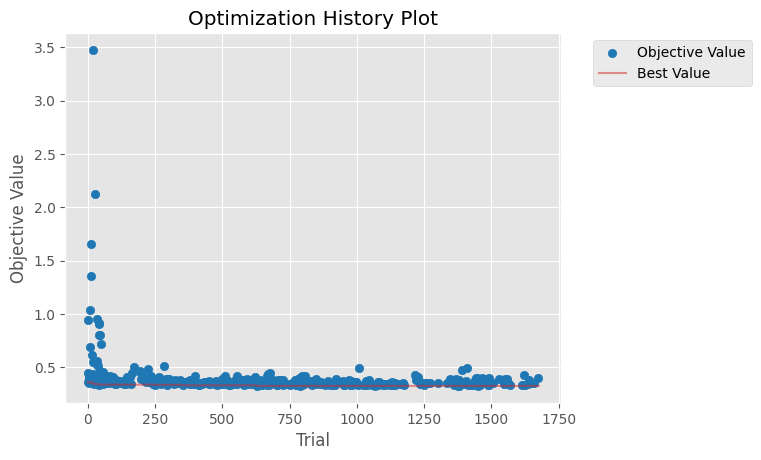

In [4]:
# overview
print("Best trial:", study.best_trial.number)
print("Best trial value:", study.best_trial.value)
print("Best trial hyperparameters:", study.best_trial.params)
optuna.visualization.matplotlib.plot_optimization_history(study)

C:\Users\12196478\AppData\Local\Temp\ipykernel_14948\533990084.py:1: ExperimentalWarning: plot_contour is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_contour(study, params=["conv_layers", "dense_layers"])
[W 2024-04-16 12:53:32,984] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='conv_layers', ylabel='dense_layers'>

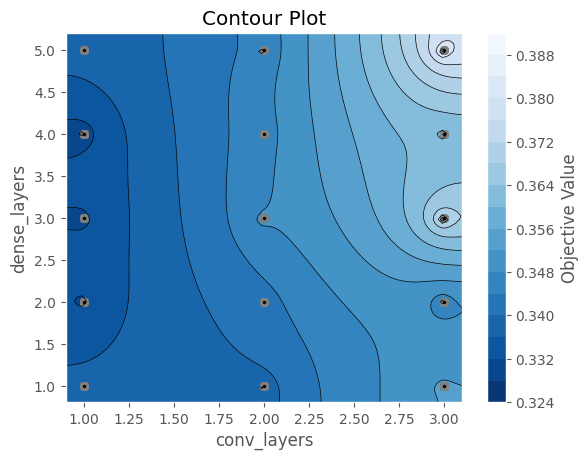

In [5]:
optuna.visualization.matplotlib.plot_contour(study, params=["conv_layers", "dense_layers"])

In [6]:
study_results = study.trials_dataframe().query("number <= 1499")
study_results.groupby("state").size()

state
COMPLETE     410
FAIL           7
PRUNED      1083
dtype: int64

In [7]:
best = study_results.query(f"number == {study.best_trial.number}")
best

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_conv_1_kernel_size,params_conv_1_kernels,params_conv_2_kernel_size,params_conv_2_kernels,...,params_lr_init,params_lr_min_ratio,params_reg_beta,user_attrs_metric_calibration_mse,user_attrs_metric_calibration_rmse,user_attrs_metric_tuning_mse,user_attrs_metric_tuning_rmse,user_attrs_trained_epochs,system_attrs_fixed_params,state
629,629,0.326409,2024-03-25 23:33:22.672401,2024-03-26 00:06:05.282482,0 days 00:32:42.610081,192,69,19,NaN,NaN,...,0.000288,0.05,0.021,0.314516,0.560817,0.364005,0.603328,750.0,NaN,COMPLETE


## Evaluate particular model

In [8]:
TRIAL_NUMBER = None

In [9]:
# load trial model and predictions
trial_number = TRIAL_NUMBER if TRIAL_NUMBER else study.best_trial.number
model_name = f"trial_{trial_number}"
model = tf.keras.models.load_model(
    filepath=f"data/{STUDY_NAME}/models/eval/{model_name}.model.keras"
)
predictions = pd.read_pickle(f"data/{STUDY_NAME}/models/eval/predict/{model_name}.pkl")
# predictions = predictions.query("subsequent_flag_1 == 0")

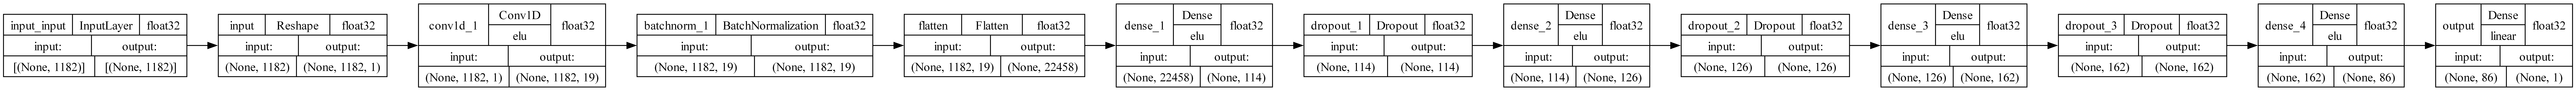

In [10]:
tf.keras.utils.plot_model(
    model=model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=True,
    # show_layer_names=True,
    rankdir="LR",
    # expand_nested=True,
    dpi=600,
    show_layer_activations=True,
    # show_trainable=True,
)


In [11]:
train_instruments = (
    predictions.query("partition == 'train'")
    # predictions.query("season in (2015, 2016, 2017, 2018)")
    .groupby(["instrument"])
    .size()
    .reset_index()
)["instrument"].to_list()

In [12]:
test_sets = {
    "training": "partition == 'train'",
    # "training_calibration": "partition == 'train' and train_partition == 'calibration'",
    # "training_tuning": "partition == 'train' and train_partition == 'tunning'",
    
    "validation_same_instruments": f"subsequent_flag_1 == 0 and partition == 'validation' and instrument in ({train_instruments})",
    "validation_diff_instruments": f"subsequent_flag_1 == 0 and partition == 'validation' and instrument not in ({train_instruments})",
    
    "validation": "subsequent_flag_1 == 0 and partition == 'validation'",
    # "season 2018": "subsequent_flag_1 == 0 and season == 2018",
    # "season 2019": "subsequent_flag_1 == 0 and season == 2019",
    # "anderson*": "partition_ext == 'anderson_external_val'",
    # "anderson": "subsequent_flag_1 == 0 and partition_ext == 'anderson_external_val'",
    # "walsh*": "partition_ext == 'walsh_external_val'",
    "holdout": "subsequent_flag_1 == 0 and partition == 'holdout'",
    
}

all_metrics = []
for test_set, query in test_sets.items():
    test_partition = predictions.query(query)
    metrics = study_utils.utils.calculate_metrics(
        y_true=test_partition["y_true"], 
        y_pred=test_partition["y_pred"]
    )
    metrics["test_set"] = test_set
    metrics["query"] = query
    all_metrics.append(metrics)

metrics = pd.DataFrame(all_metrics)
# metrics.to_csv(f"data/{STUDY_NAME}/models/eval/metrics/{model_name}.csv")
metrics

,n,r2,rmse,sep,bias,rpd,test_set,query
0,55470,0.943852,0.569648,0.568791,0.031331,4.226596,training,partition == 'train'
1,7450,0.885045,0.877617,0.875433,-0.062692,2.956969,validation_same_instruments,subsequent_flag_1 == 0 and partition == 'valid...
2,5089,0.843432,1.077697,1.068795,0.139045,2.548556,validation_diff_instruments,subsequent_flag_1 == 0 and partition == 'valid...
3,12539,0.867488,0.963841,0.963688,0.019184,2.747626,validation,subsequent_flag_1 == 0 and partition == 'valid...
4,2996,0.809961,1.078175,1.054775,0.224237,2.345205,holdout,subsequent_flag_1 == 0 and partition == 'holdout'


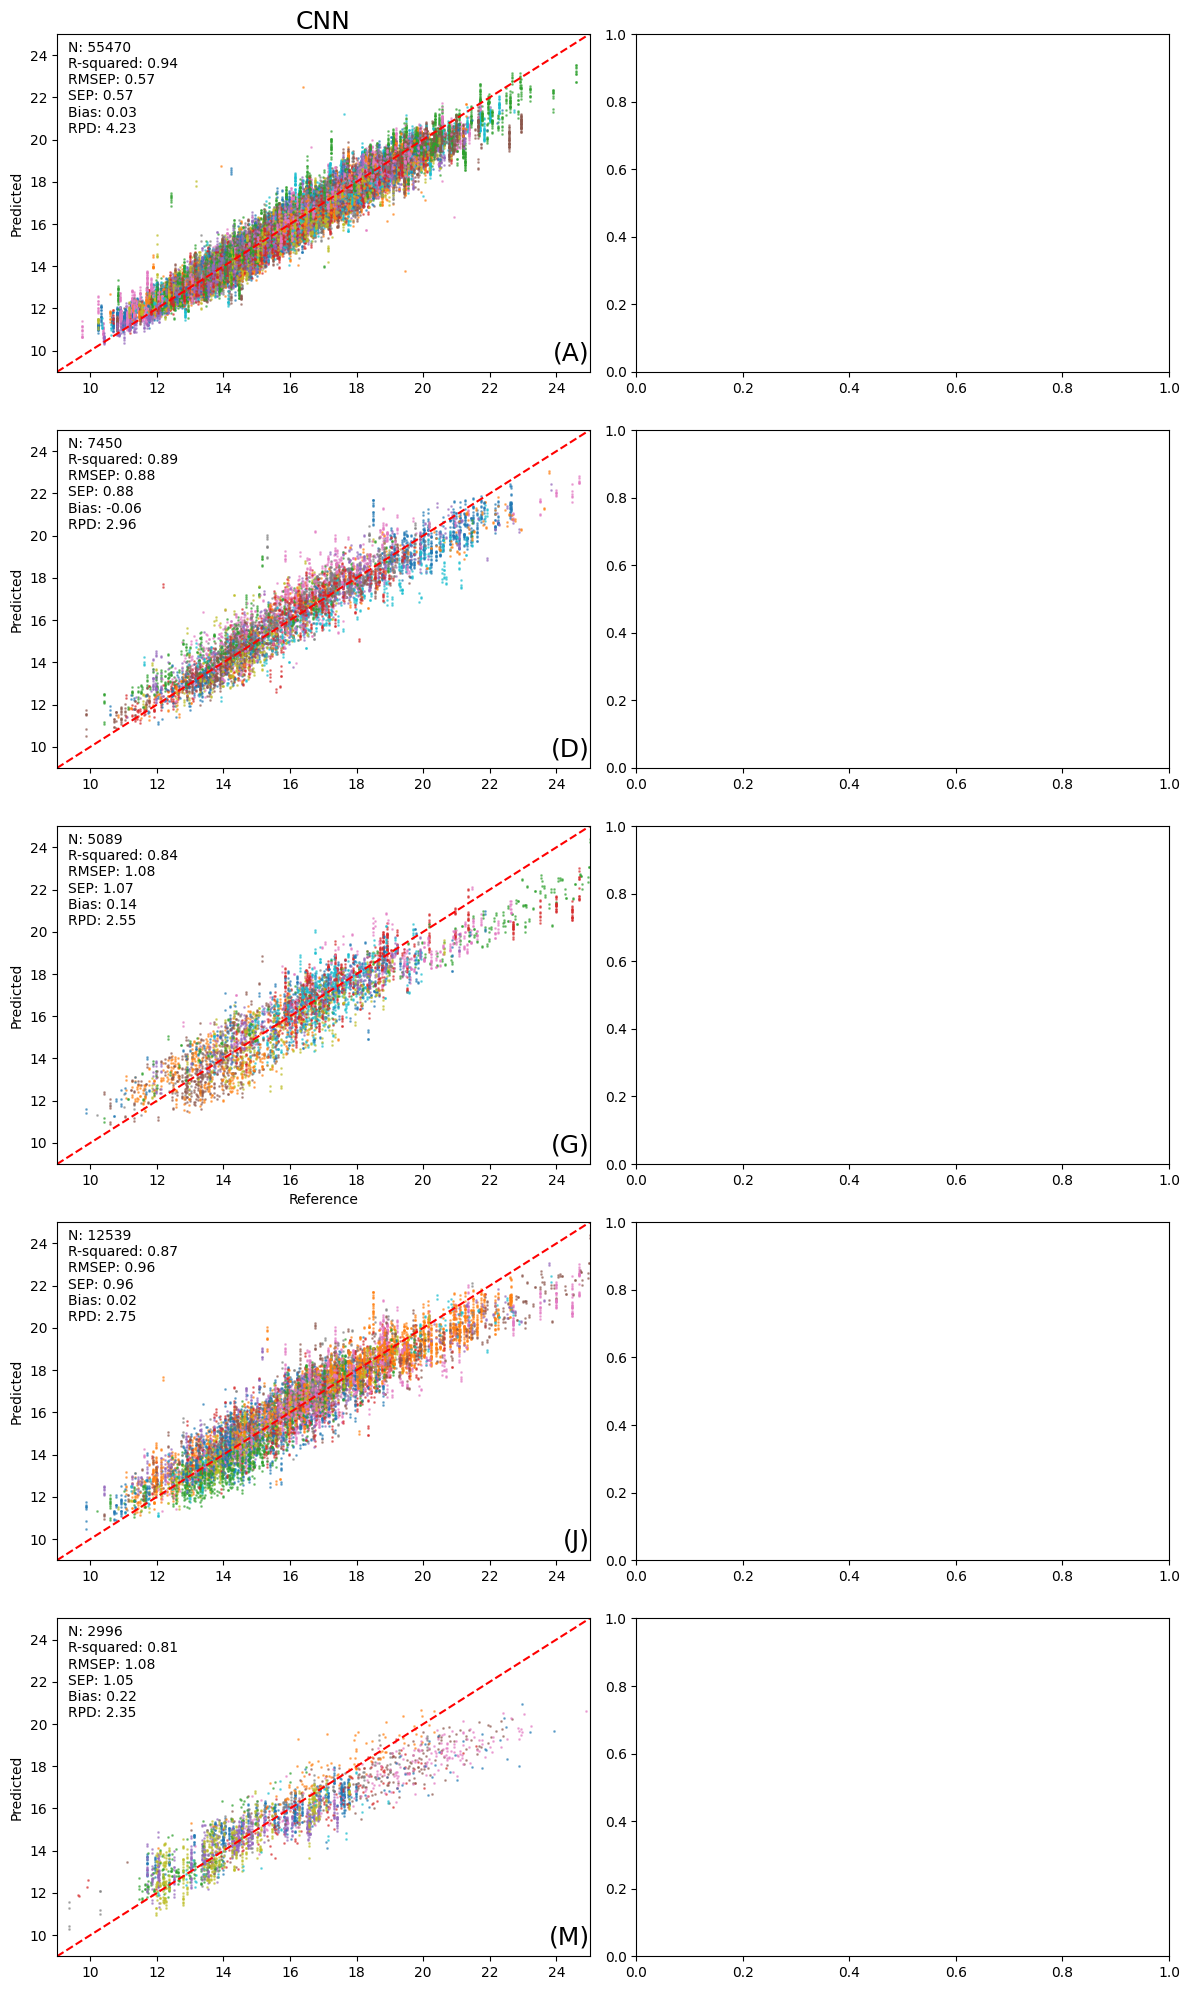

In [13]:
remove_subsequently_flagged = False

# create a figure with subplots - 4 rows (one for each query) and 3 columns (one for each model)
# plt.style.use('seaborn-v0_8-whitegrid')
plt.style.use('default')
fig, axes = plt.subplots(len(test_sets), 2, figsize=(12, 4*len(test_sets)))

# global min and max for axis scaling
global_min, global_max = 9, 25
test_sets


for i, (key, query) in enumerate(test_sets.items()):
    models = {
        "CNN": predictions.query(query),
    }
    if remove_subsequently_flagged:
        models = {
            "CNN": predictions.query(query),
        }
    
    # calculate metrics for each model
    metrics = {}
    for model_name, data in models.items():
        metrics[model_name] = study_utils.utils.calculate_metrics(
            y_true=models[model_name]["y_true"], 
            y_pred=models[model_name]["y_pred"]
        )
    stats = {}
    for model_name, metric in metrics.items():
        stats[model_name] = f"N: {metric['n']}\nR-squared: {round(metric['r2'], 2)}\nRMSEP: {round(metric['rmse'], 2)}\nSEP: {round(metric['sep'], 2)}\nBias: {round(metric['bias'], 2)}\nRPD: {round(metric['rpd'], 2)}"
    
    # plotting
    for j, (model_name, data) in enumerate(models.items()):
        ax = axes[i, j] if len(test_sets) > 1 else axes[j]  # Handle indexing for axes
        
        # generate color mapping for populations
        unique_populations = data["population"].unique()
        for population in unique_populations:
            data_p = data[data["population"] == population]
            ax.scatter(data_p["y_true"], data_p["y_pred"], s=1, alpha=0.5)
        ax.plot([global_min, global_max], [global_min, global_max], linestyle='--', color='red')
        
        if j in [0]: 
            ax.set_ylabel("Predicted")
            
        if i in [0]: 
            ax.set_title(model_name, fontsize=18, pad=-2)
            
        if i == len(models.items()) + 1: 
            # Only set xlabel for the bottom subplot
            ax.set_xlabel("Reference")
        
        ax.text(0.02, 0.98, stats[model_name], transform=ax.transAxes, fontsize=10, ha='left', va='top')
        title_label = chr(65 + i*3 + j)
        ax.text(1.0, 0.02, f"({title_label})", transform=ax.transAxes, fontsize=18, ha='right', va='bottom') 
        
        ax.set_xlim(global_min, global_max)
        ax.set_ylim(global_min, global_max)
        


plt.tight_layout()
plt.show()


In [14]:
df = study_results.query("state == 'COMPLETE'")
df.columns

Index(['number', 'value', 'datetime_start', 'datetime_complete', 'duration',
       'params_batch_size', 'params_conv_1_kernel_size',
       'params_conv_1_kernels', 'params_conv_2_kernel_size',
       'params_conv_2_kernels', 'params_conv_3_kernel_size',
       'params_conv_3_kernels', 'params_conv_layers', 'params_dense_1_dropout',
       'params_dense_1_units', 'params_dense_2_dropout',
       'params_dense_2_units', 'params_dense_3_dropout',
       'params_dense_3_units', 'params_dense_4_dropout',
       'params_dense_4_units', 'params_dense_5_units', 'params_dense_layers',
       'params_lr_init', 'params_lr_min_ratio', 'params_reg_beta',
       'user_attrs_metric_calibration_mse',
       'user_attrs_metric_calibration_rmse', 'user_attrs_metric_tuning_mse',
       'user_attrs_metric_tuning_rmse', 'user_attrs_trained_epochs',
       'system_attrs_fixed_params', 'state'],
      dtype='object')

C:\Users\12196478\AppData\Local\Temp\ipykernel_14948\3213279568.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("params_conv_layers", inplace=True)
C:\Users\12196478\AppData\Local\Temp\ipykernel_14948\3213279568.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values("params_dense_layers", inplace=True)


TypeError: Axes.boxplot() got an unexpected keyword argument 'hue'

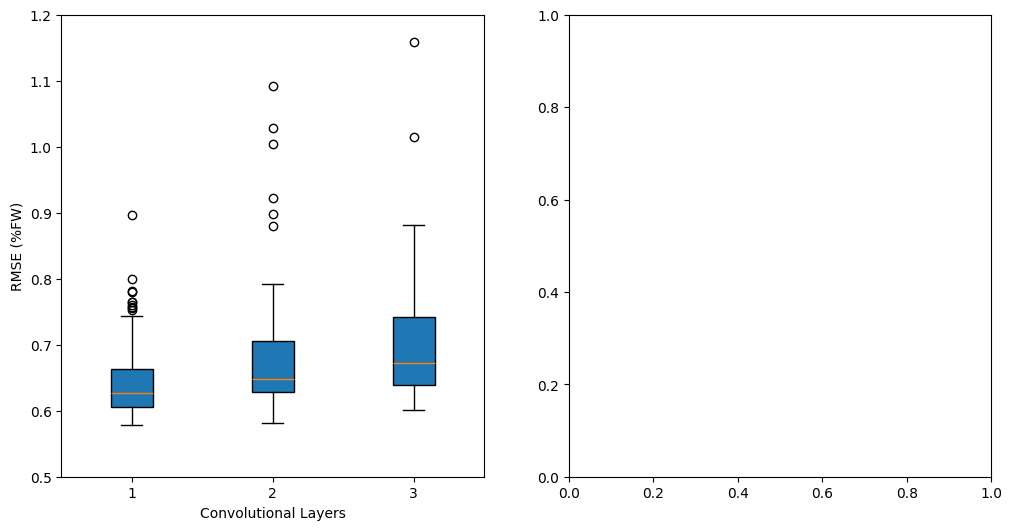

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Two plots in one row

# First plot
df.sort_values("params_conv_layers", inplace=True)
axs[0].boxplot(
    [df['user_attrs_metric_tuning_rmse'][df['params_conv_layers'] == category] for category in df['params_conv_layers'].unique()],
    labels=df['params_conv_layers'].unique(),
    patch_artist=True,
)
axs[0].set_xlabel("Convolutional Layers")
axs[0].set_ylabel("RMSE (%FW)")
axs[0].set_ylim(0.5, 1.2)
axs[0].grid(False)

# Second plot
df.sort_values("params_dense_layers", inplace=True)
axs[1].boxplot(
    [df['user_attrs_metric_tuning_rmse'][df['params_dense_layers'] == category] for category in df['params_dense_layers'].unique()],
    labels=df['params_dense_layers'].unique(),
    patch_artist=True,
)
axs[1].set_xlabel("Dense Layers")
axs[1].set_ylim(0.5, 1.2)
axs[1].grid(False)

axs[0].text(0.03, 0.97, '(A)', transform=axs[0].transAxes, fontsize=18, verticalalignment='top')
axs[1].text(0.03, 0.97, '(B)', transform=axs[1].transAxes, fontsize=18, verticalalignment='top')

plt.tight_layout()
plt.show()

In [30]:
mean_rmse['params_dense_layers']

NameError: name 'mean_rmse' is not defined

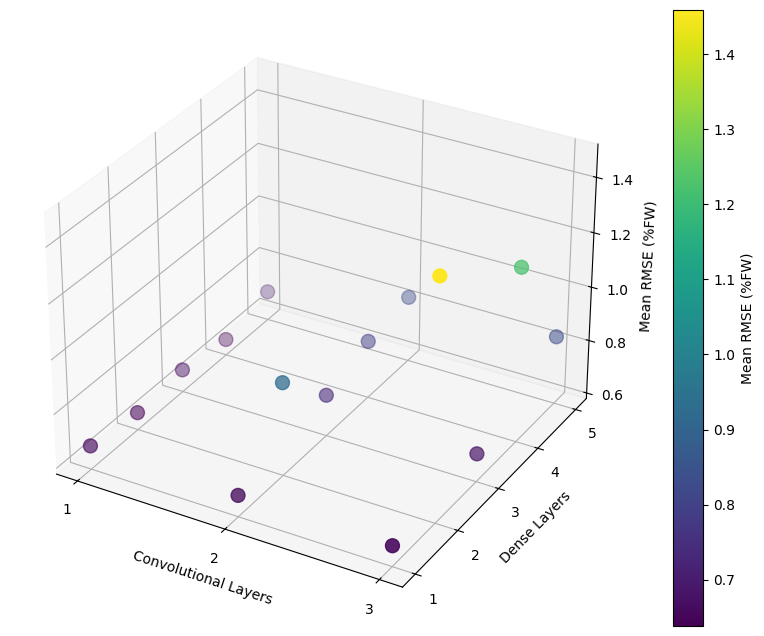

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Calculating mean RMSE for each combination of convolutional and dense layers
mean_rmse = df.groupby(['params_conv_layers', 'params_dense_layers'])['user_attrs_metric_tuning_rmse'].mean().reset_index()

# 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Data for plotting
x = mean_rmse['params_conv_layers']
y = mean_rmse['params_dense_layers']
z = mean_rmse['user_attrs_metric_tuning_rmse']

# Scatter plot
sc = ax.scatter(x, y, z, c=z, cmap='viridis', s=100)

# Adding labels and title
ax.set_xlabel('Convolutional Layers')
ax.set_ylabel('Dense Layers')
ax.set_zlabel('Mean RMSE (%FW)')

ax.set_xticks(np.arange(min(x), max(x)+1, 1))
ax.set_yticks(np.arange(min(y), max(y)+1, 1))

# Color bar
cbar = plt.colorbar(sc)
cbar.set_label('Mean RMSE (%FW)')

plt.show()


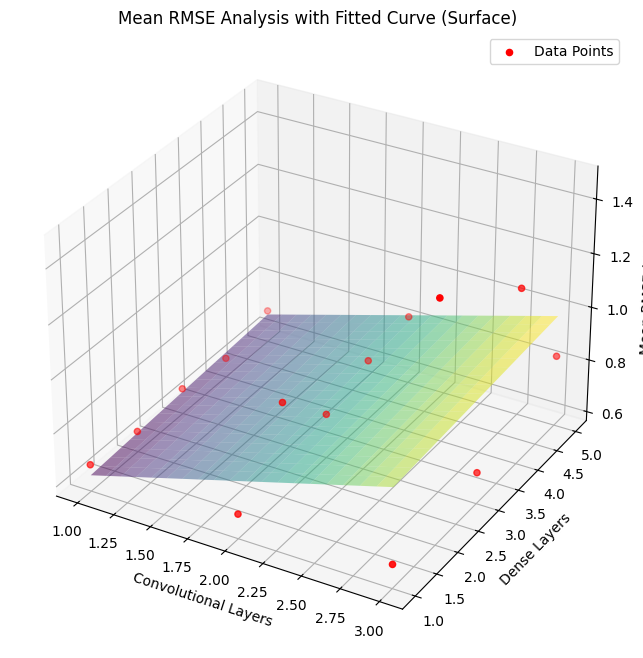

In [ ]:
from scipy.optimize import curve_fit

# Defining a function for the curve (assuming a simple linear relationship for demonstration)
def model(x, a, b):
    return a * x + b

# Preparing data for curve fitting
# Flatten arrays to fit the curve across both parameters together
X = np.column_stack((x, y))
y_data = z

# Since we're dealing with a 3D space and looking to fit a curve (more appropriately, a surface), we need to adjust our approach.
# We'll demonstrate fitting a plane as a simple example, using both parameters (convolutional and dense layers).
# Note: This simplifies the problem significantly and may not capture complex relationships.

# Curve fitting requires a 1D array for the independent variable. We'll create a combined index to work around this.
def model_2d(x, a, b, c):
    return a * x[:, 0] + b * x[:, 1] + c

# Fit the model
params, _ = curve_fit(model_2d, X, y_data)

# Parameters for the plane
a, b, c = params

# Generating a meshgrid for the surface plot
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 20)
y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 20)
x_grid, y_grid = np.meshgrid(x_range, y_range)
z_grid = model_2d(np.column_stack((x_grid.ravel(), y_grid.ravel())), a, b, c).reshape(x_grid.shape)

# Plotting the original data points and the fitted surface
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Original data points
sc = ax.scatter(x, y, z, c='red', label='Data Points')

# Fitted surface
ax.plot_surface(x_grid, y_grid, z_grid, alpha=0.5, cmap='viridis')

# Adding labels and title
ax.set_xlabel('Convolutional Layers')
ax.set_ylabel('Dense Layers')
ax.set_zlabel('Mean RMSE (%FW)')
ax.set_title('Mean RMSE Analysis with Fitted Curve (Surface)')

ax.legend()

plt.show()
